In [1]:
import itertools
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
file_path = './dataset/'
train_fn = 'FordA_TRAIN.arff'
test_fn = 'FordA_TEST.arff'

def read_ariff(path):
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0], len(cols)])

    for i, col in zip(range(len(cols)), cols):
        data2d[:, i]=raw_data[col]
    return data2d

train =  read_ariff(file_path + train_fn)
test = read_ariff(file_path + test_fn)

In [3]:
print('train_set.shape:', train.shape)
print('test_set.shape:', test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


In [4]:
x_train_temp = train[:,:-1]
y_train_temp = train[:,-1]

x_test = test[:, :-1]
y_test = test[:, -1]

In [5]:
normal_x = x_train_temp[y_train_temp==1]
abnormal_x = x_train_temp[y_train_temp==-1]
normal_y = y_train_temp[y_train_temp==1]
abnormal_y = y_train_temp[y_train_temp==-1]

x_train_normal, x_valid_normal, y_train_normal, y_valid_normal = train_test_split(
    normal_x, normal_y, test_size=0.2, random_state=42, stratify=normal_y)

x_train_abnormal, x_valid_abnormal, y_train_abnormal, y_valid_abnormal = train_test_split(
    abnormal_x, abnormal_y, test_size=0.2, random_state=42, stratify=abnormal_y)

x_train = np.concatenate((x_train_normal, x_train_abnormal), axis=0)
y_train = np.concatenate((y_train_normal, y_train_abnormal), axis=0)

x_valid = np.concatenate((x_valid_normal, x_valid_abnormal), axis=0)
y_valid = np.concatenate((y_valid_normal, y_valid_abnormal), axis=0)

In [6]:
print('x_train.shape:', x_train.shape)
print('x_valid.shape:', x_valid.shape)
print('y_train.shape:', y_train.shape)
print('y_valid.shape:', y_valid.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (2880, 500)
x_valid.shape: (721, 500)
y_train.shape: (2880,)
y_valid.shape: (721,)
x_test.shape: (1320, 500)
y_test.shape: (1320,)


## 3.데이터 전처리

#### 3.1 데이터 정규화

- 동일 시간 길이(3,600) 내 센서 값들이 넓은 범위로 퍼져있다.

- 변수 간의 Scale이 서로 다르기 때문에, 데이터를 그대로 학습하는 것은 적절하지 않다.

- 인풋 값들을 정규화(Normalization)을 한다.

- 흔히 공정 데이터에는 이상치(Outlier)가 발생할 수 있는데 강건한 정규화가 필요할 때 RobustScaler를 사용한다.

- StandScaler는 보다 더 일반적으로 사용하는 정규화 방법

    - 데이터를 단위 분산으로 조정함으로써 Outlier에 취약할 수 있음     

- RobustScaler는 Feature간 스케일을 갖게 되지만 평균과 분산 대신 중간 값(median)과 사분위값(quartile)을 사용 -> 극단값(Outlier)에 영향을 받지 않음

In [7]:
print("x_train shape:", x_train.shape)  # (num_samples, num_features)
print("x_valid shape:", x_valid.shape)  # (num_samples, num_features)

x_train shape: (2880, 500)
x_valid shape: (721, 500)


In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

stder = StandardScaler()
stder.fit(x_train)
x_train = stder.transform(x_train)
x_valid = stder.transform(x_valid)

# rscaler = RobustScaler()
# rscaler.fit(x_train)
# x_train = rscaler.transform(x_train)
# x_valid = rscaler.transform(x_valid)

#### 3.2 데이터 형태 변환


In [9]:
y_train[y_train == -1] = 0
y_valid[y_valid == -1] = 0
y_test[y_test == -1] = 0

In [10]:
x_train_exp = np.expand_dims(x_train, -1)
x_valid_exp = np.expand_dims(x_valid, -1)
x_test_exp = np.expand_dims(x_test, -1)

# x_train_exp = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_valid_exp = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], 1))
# x_test_exp = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print('x_train_exp의 형태:', x_train_exp.shape)
print('x_valid_exp의 형태:', x_valid_exp.shape)
print('x_test_exp의 형태:', x_test_exp.shape)

x_train_exp의 형태: (2880, 500, 1)
x_valid_exp의 형태: (721, 500, 1)
x_test_exp의 형태: (1320, 500, 1)


## 5.결과 분석 및 해석

##### (1) Confustion Matrix

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

def draw_confusion_matrix(model, xt, yt, model_name):
    Y_pred = model.predict(xt)

    if model_name in ['cnn', 'rnn']:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred

    plt.figure(figsize=(3,3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max()/1.2
    normalize = False

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                        horizontalalignment = 'center',
                        color = 'white' if cm[i, j] > thresh else 'black',
                        fontsize = 12)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_cm.png', dpi=100, bbox_inches='tight')
    plt.show()

    print(classification_report(yt, y_pred))

##### (2) ROC Curve

In [12]:
from sklearn.metrics import roc_curve, auc

def draw_roc(model, xt, yt, model_name):
    Y_pred = model.predict(xt)

    if model_name in ['cnn', 'rnn']:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred

    fpr, tpr, thr = roc_curve(yt, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
                        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model_name))
    plt.legend(loc='lower right')
    plt.ion()
    plt.tight_layout
    plt.savefig(f'{model_name}_roc.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (3) Epoch에 따른 학습 & 검증의 손실(loss) 그래프


In [28]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training & Validation Loss')
    plt.ylabel('loss', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}_loss.png', dpi=100, bbox_inches='tight')
    plt.show()

##### (4) Epoch에 따른 정확도(Accuracy Rate) 그래프

In [35]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model'+'Prediction Accuracy')
    plt.ylabel('sparse_categorical_accuracy', fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(f'{pic_name}_auc.png', dpi=100, bbox_inches='tight')
    plt.show()

## 4. 모델 구축 및 설계

#### 4.4 합성곱 신경망(Convolutional Neural Network)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv1D, ReLU, GlobalAveragePooling1D, Dense

def make_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(2, activation='softmax'))
    return model

cnn_model = make_cnn_model()

In [50]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

epoch = 300
batch_size = 64

callbacks = [
    ModelCheckpoint('cnn_best_model.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monior='val_loss', factor=0.5, patience=20, min_lr=0.0001),
    EarlyStopping(monitor='val_loss', patience=50, verbose=1),
]

cnn_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

history_cnn = cnn_model.fit(
    x_train_exp,
    y_train,
    batch_size=batch_size,
    epochs=epoch,
    callbacks=callbacks,
    validation_data=(x_valid_exp, y_valid),
    verbose=1,
)

Epoch 1/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3101 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.2946 - val_sparse_categorical_accuracy: 0.8849
Epoch 2/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.8813 - val_loss: 0.2805 - val_sparse_categorical_accuracy: 0.8904
Epoch 3/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2856 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.3025 - val_sparse_categorical_accuracy: 0.8724
Epoch 4/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2916 - sparse_categorical_accuracy: 0.8828 - val_loss: 0.2802 - val_sparse_categorical_accuracy: 0.8960
Epoch 5/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2812 - sparse_categorical_accuracy: 0.8865 - val_loss: 0.2806 - val_sparse_categorical_accuracy: 0.8974
Epoch 6/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2906 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.2786 - val_sparse_categorical_accuracy: 0.8932
Epoc

In [51]:
from tensorflow.keras.models import load_model

cnn_model = tf.keras.models.load_model('cnn_best_model.keras')
scores = cnn_model.evaluate(x_test_exp, y_test)

print('\n''Test accuracy', scores[1])
print('\n''Test loss', scores[0])
print('%s: %.2f%%' % (cnn_model.metrics_names[1], scores[1]*100))

#Test accuracy 0.9666666388511658
# Test loss 0.09676112979650497
# compile_metrics: 96.67%

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2565 - sparse_categorical_accuracy: 0.9089

Test accuracy 0.8886363506317139

Test loss 0.2734611928462982
compile_metrics: 88.86%


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


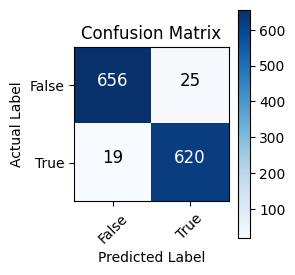

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       681
         1.0       0.96      0.97      0.97       639

    accuracy                           0.97      1320
   macro avg       0.97      0.97      0.97      1320
weighted avg       0.97      0.97      0.97      1320



In [24]:
draw_confusion_matrix(cnn_model, x_test_exp, y_test, 'cnn')

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


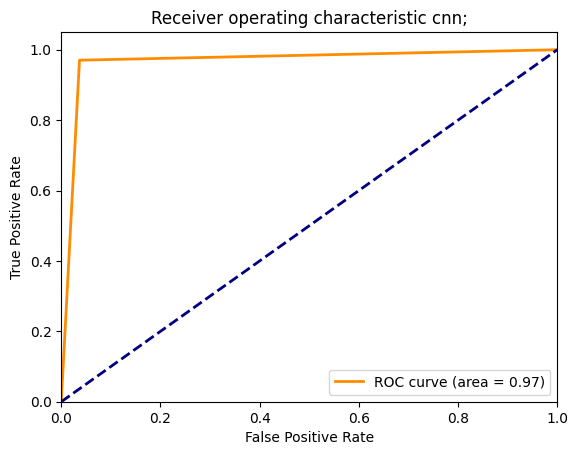

In [25]:
draw_roc(cnn_model, x_test_exp, y_test, 'cnn')

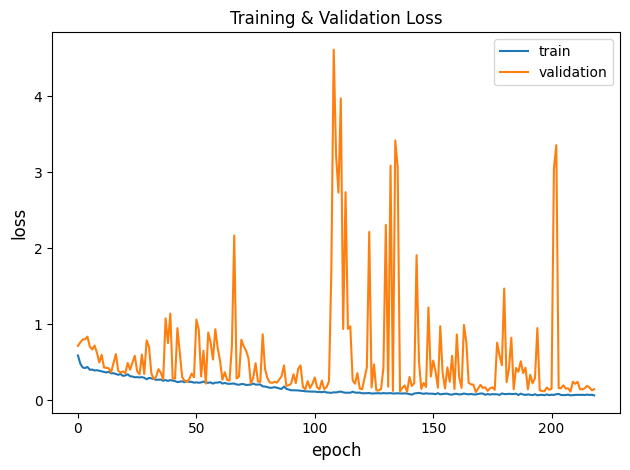

In [30]:
plot_loss_graph(history_cnn, 'cnn')

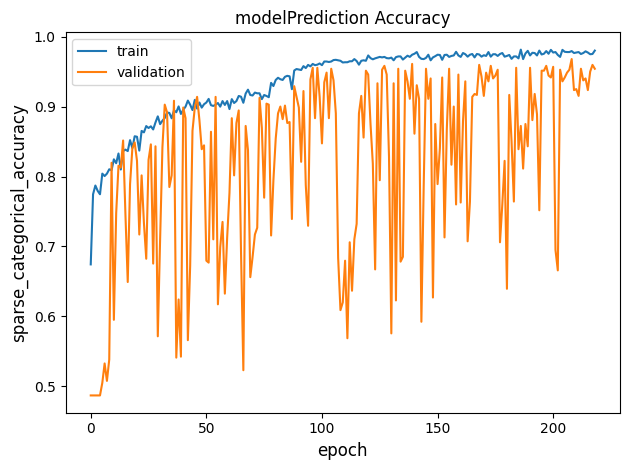

In [36]:
plot_prediction_graph(history_cnn, 'cnn')